# Computer Tomography

## Radon Tranformation

##### Required packages

Packages used:
* matplotlib - plotting images
* skimage - reading images into memory (can be replaced with opencv)
* numpy - all matrices operations
* math - for beam equation calculations

In [2]:
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install scikit-image
!{sys.executable} -m pip install matplotlib

from skimage import io
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import numpy as np
import math

from IPython.display import clear_output

clear_output()

## 1. Emiters and detectors

According to Wikipedia:
> CT scanners use a rotating X-ray tube and a row of detectors placed in the gantry to measure X-ray attenuations by different tissues inside the body. The multiple X-ray measurements taken from different angles are then processed on a computer using reconstruction algorithms to produce tomographic (cross-sectional) images (virtual "slices") of a body.

In computed tomography we can create two models of X-ray rays: **parallel rays** and **fan rays**. In the **parallel** option the amount of emitters and detectors is the same - <u>one</u> detector is detecting <u>one</u> ray of light from <u>one</u> emitter.  In the **fan** option only <u>one emitter</u> is used, but the rays are sent towards the scanned object at different angles. Thanks to that multiple rays from <u>one</u> emitter hit <u>multiple</u> detectors at the opposite side. Because in testing both approaches returned similar results (with only exception being that fan rays can rotate 360 degrees without duplicate images after 180-th degree) the preferred method will be **parallel rays**.

In mathematics we can derive the point in a circle (which in reality is a CT machine) at an angle using following equations:

$$x = r \times cos(\alpha)$$
$$y = r \times sin(\alpha)$$

We have to generate multiple detector locations that are distant from each other at relatively equally distributed distance. In that case if we consider $\alpha$ to be the position of the detector in the middle, then we can calculate position of $n$ detectors using the following equation for $i$-th iteration (where $\phi$ is the span of the rays): 

$$x_d = r \times cos(\alpha - (i \times \frac{\phi}{n-1}) + \frac{\phi}{2})$$
$$y_d = r \times sin(\alpha - (i \times \frac{\phi}{n-1}) + \frac{\phi}{2})$$

Next we can calculate the locations of emitters on the opposite side of the circle by adding $\pi$ like in the following equation:

$$x_e = r \times cos(\alpha + \pi - \frac{\phi}{2} + (i \times \frac{\phi}{n-1}))$$
$$y_e = r \times sin(\alpha + \pi - \frac{\phi}{2} + (i \times \frac{\phi}{n-1}))$$

Where obviously $r$ is the radius of the circle.
During calculations it is important to realize that in standard visualisation libraries for python (such as matplotlib, which will be used later on) have the beginning of their axis dislocated. Because of this we have to move the points later on in the euqations to return to standard mathematical situation.

In [3]:
# This is a function which calculates the equations above
def get_parallel_rays(radius, pos, angle=45, span=120, num_rays=20):
    '''
    Calculate the locations of emitters and detectors for given parameters.
    :param radius: - radius of a circle
    :param pos: - position of the middle of axis (this is how we move the dislocated axis in it's proper position)
    :param angle: - angle from which rays are casted (alpha in the equations)
    :param span: - span of the rays (phi in the equations)
    :param num_rays: - number of emitters/detectors (n in equations)
    '''
    # Remove this is you are passing radians instead of degrees
    alpha = math.radians(angle)
    theta = math.radians(span)

    rays = []
    for ray in range(num_rays):
        # Calculate detectors
        x_d = radius * math.cos(alpha - (ray * theta/(num_rays-1)) + theta/2) + pos[0]
        y_d = radius * math.sin(alpha - (ray * theta/(num_rays-1)) + theta/2) + pos[1]
        # Calculate emitters
        x_e = radius * math.cos(alpha + math.pi - (theta/2) + (ray * theta/(num_rays-1))) + pos[0]
        y_e = radius * math.sin(alpha + math.pi - (theta/2) + (ray * theta/(num_rays-1))) + pos[1]
        rays.append([[x_d, x_e], [y_d, y_e]])
    
    return rays

### Visualization

Let's test the function above. We will draw a circle with radius equal to $0.4$. Then we will cast $50$ rays at angle $\alpha = 45^0$. The span of the cone will be qual to $180^0$. In order to properly visualize the object we will draw (indicated by a square manually drawn) we will set the position of the center of the axis at $(0.6, 0.6)$.

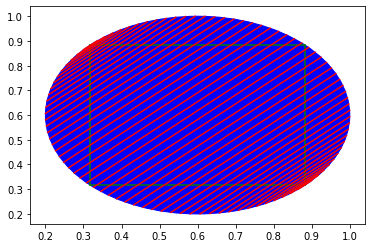

In [4]:
# Center of the axis
pos = (0.6, 0.6)
# Cicle radius
r = 0.4
# Degree of middle ray
alpha = 45
# Span of ray cone
span = 180
# Number of rays
num_rays = 50

# Draw a circle (symbolic image of CT machine)
circle = plt.Circle(pos, r, color='blue')
fig, ax = plt.subplots()

ax.add_patch(circle)

# Get the length of the side of the square that will be drawn inside of the circle
edge = math.sqrt(r * r * 2)

# Square vertices
x_1 = pos[0] - (edge/2)
x_e = pos[0] - (edge/2) + edge
y_1 = pos[1] - (edge/2)
y_e = pos[1] - (edge/2) + edge

# Square edges
a = [[x_1, x_e], [y_1, y_1]]
b = [[x_1, x_1], [y_1, y_e]]
c = [[x_1, x_e], [y_e, y_e]]
d = [[x_e, x_e], [y_1, y_e]]

# Draw the square
ax.plot(a[0], a[1], color="green")
ax.plot(b[0], b[1], color="green")
ax.plot(c[0], c[1], color="green")
ax.plot(d[0], d[1], color="green")

rays = get_parallel_rays(r, pos, alpha, span, num_rays)

# Draw the rays that will be cast onto the image
for ray in rays:
    ax.plot([ray[0][0], ray[0][1]], [ray[1][0], ray[1][1]], color="red")

plt.show()

## 2. Sinogram - Radon transform

In order to reconstruct an image from the intensity of each point the lights pass through, we need to construct a function - dependency of pixel intensity depending on the angle of the scan.

### Calculating the ray points using Bresenham's algorithm

Because the lines we drew above not only have their coordinates in float format, but also have been calculated using matplotlib internal function, we have to come up with a way of getting the coordinates of the rays that go from the emitter location to the detector location.

A decent way to perform that operation is to use **Bresenham's algorithm**, which is commonly used in computer graphics. It will return the list of pixel coordinates that will make up each ray.

In [5]:
# Bresenham's algorithm
def get_bresenham_points(x1, x2, y1, y2):
    '''
    Get coordinates of the points in the rays.
    :param x1: - beginning of the ray on x axis
    :param x2: - the end of the ray on x axis
    :param y1: - beginning of the ray on y axis
    :param y2: - the end of the ray on y axis
    '''
    # Convert float back to integer
    x1, y1 = int(x1), int(y1)
    x2, y2 = int(x2), int(y2)
    dx = x2 - x1
    dy = y2 - y1

    # Check the variables to prevent errors
    # -------------------------------------------------------------

    # Determine the leading axis
    is_steep = abs(dy) > abs(dx)

    # If the y axis is the leading axis, invert the ray beginning and end locations - otherwise if the degree is equal
    # to 90 degrees, we will get a Zero Division exception
    if is_steep:
        x1, y1 = y1, x1
        x2, y2 = y2, x2

    # If the coordinates are passed in reversed order, fix that
    swapped = False
    if x1 > x2:
        x1, x2 = x2, x1
        y1, y2 = y2, y1
        swapped = True

    # The main logic
    # -------------------------------------------------------------

    # Calculate the differences again after fixing the input
    dx = x2 - x1
    dy = y2 - y1

    # Calculate error
    error = int(dx / 2.0)
    ystep = 1 if y1 < y2 else -1

    # Calculate points that are in the ray
    y = y1
    points = []
    for x in range(x1, x2 + 1):
        coord = (y, x) if is_steep else (x, y)
        points.append(coord)
        # Reducing the error (moving towards the end of the ray)
        error -= abs(dy)
        if error < 0:
            y += ystep
            error += dx

    # Reverse the points if they were swapped
    if swapped:
        points.reverse()
    return points

Now that we have the algorithm that will return the points on the rays we can calculate the actual **sinogram**. We need to sum the intensity of the points that were obtained using the Bresenham's algorithm and increment the angle from which we cast the rays to obtain the function of the sinogram as I mentioned before.

In [6]:
# Sinogram calculation
def calculate_sinogram(img, steps=60, span=120, num_rays=250, max_angle=180):
    '''
    Get the sinogram (angle function from intensity).
    :param img: - ndarray of the image
    :param steps: - how many steps are to be performed (how many different angles we want)
    :param span: - cone of the rays
    :param num_rays: - number of rays
    :param max_angle: - maximum angle we want to reach (going beyond this will result in duplicates)
    '''
    # Empty sinogram
    sinogram = np.zeros((steps, num_rays))
    idx = 0
    for idx in range(steps):
        # Get angle to cast rays from and calculate the emitter/detector locations
        angle = idx * (max_angle/steps)
        rays = get_parallel_rays(max(image.shape[0]//2, image.shape[1]//2)*math.sqrt(2),
                                 (image.shape[0]//2, image.shape[1]//2), angle, span, num_rays)
        for ray_idx, ray in enumerate(rays):
            # Get the points in the rays using Bresenham's algorithm
            emitter_value = 0
            points = get_bresenham_points(ray[0][0], ray[0][1], ray[1][0], ray[1][1])
            for point in points:
                # Add the intensity of the points at current angle
                # Be careful to add only points that are in the image - because we moved the image into the middle
                # some rays will go beyond the image.
                if (point[0] >= 0 and point[0] < img.shape[0]) and (point[1] >= 0 and point[1] < img.shape[1]):
                    emitter_value += img[point[0]][point[1]]
            sinogram[idx][ray_idx] = emitter_value
    return sinogram

# Inverse the sinogram (OX becomes OY and vice versa)
def transpose(sinogram):
    return [list(x) for x in list(zip(*sinogram))]

## Sinogram - visualisation

Let's try calculating an example sinogram. We will use default parameters - except for steps (we will do a measurement every degree). For the image you can use whatever you want. I'm going to use the infamous Shepp-Logan phantom, but feel free to change the location of the image to your liking. Let it run for a moment - it will take a while.

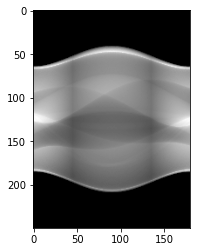

In [11]:
# Replace the filename below to change image, the rest stays the same.
image = io.imread("Shepp_logan.jpg")
image = rgb2gray(image)

sinogram = calculate_sinogram(image, steps=180)
plt.imshow(transpose(sinogram), cmap="gray", aspect='equal')

## 3. Image reconstruction - Inverse Radon Transform (Backprojection)

In order to reconstruct the image we need to perform **inverse Radon tranform** also known as Backprojection. We will absically do all that we did until now, but in reverse. Calculate the emitter and detector locations and points that create them, then add sums from the sinogram this time in order to obtain pixel intensity.

We will also need to normalize the result, so that the resulting intensity will not go beyond $255$.

In [12]:
# Normalization
def normalize(sinogram, maximum):
    '''
    Normalize the values in the array by dividing them by the maximum value.
    :param sinogram: - input sinogram to normalize
    :param maximum: - maximum value to divide by
    '''
    for i in range(len(sinogram)):
        for j in range(len(sinogram[i])):
            sinogram[i][j] = sinogram[i][j] / maximum
    return sinogram


# Backprojection
def reverse_radon_transform(sinogram, steps=60, span=120, num_rays=250, max_angle=180):
    '''
    Backprojection (get reconstructed image).
    :param sinogram: - input sinogram
    :param steps: - how many measurements there were in the sinogram construction
    :param span: - span of the rays that created the sinogram
    :param num_rays: - number of rays creating the sinogram
    :param max_angle: - maximum angle the sinogram reached
    '''
    # Empty result image
    width = image.shape[0]
    height = image.shape[1]
    out_image = np.zeros((image.shape[0], image.shape[1]))
    error = []
    maximum = -1
    
    for idx in range(steps):
        # Again, get angle and emitter/detector locations
        angle = idx * max_angle/steps
        rays = get_parallel_rays(max(image.shape[0]//2, image.shape[1]//2)*math.sqrt(2),
                                 (image.shape[0]//2, image.shape[1]//2), angle, span, num_rays)
        for ray_idx, ray in enumerate(rays):
            # Get points that create the rays
            points = get_bresenham_points(ray[0][0], ray[0][1], ray[1][0], ray[1][1])
            for point in points:
                # Like before, add intensity from sinogram, only for pixels that belong in the image
                if (point[0] >= 0 and point[0] < image.shape[0]) and (point[1] >= 0 and point[1] < image.shape[1]):
                    out_image[point[0]][point[1]] += sinogram[idx][ray_idx]
                    # Get maximum pixel intensity for later normalization
                    if out_image[point[0]][point[1]] > maximum:
                        maximum = out_image[point[0]][point[1]]
    return normalize(out_image, maximum)

## Backprojection - reconstruction

Let's see the result of the backprojection. Like before we will reconstruct the image using standard parameters and use Shepp-Logan phantom for reference. Again - it will take a bit longer.

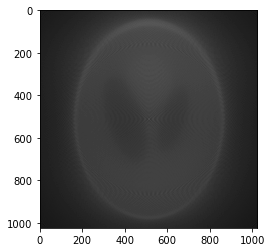

In [13]:
# Replace the filepath to get reconstruction for a different image
image = io.imread("Shepp_logan.jpg")
image = rgb2gray(image)
sinogram = calculate_sinogram(image, steps=180)
out_image = reverse_radon_transform(sinogram, steps=180)
plt.imshow(out_image, cmap="gray")

## 4. Filtering (convolution)

There is one problem with the image above - it has quite a lot of noise that we would like to reduce. In order to do that we will use convolution on the **sinogram** and **output image**. We will use kernel to scan and fix each pixel.

In [14]:
# Sinogram convolution
def convolve_sinogram(img, kernelSize=9):
    width = len(img)
    imgNew = []
    for i in range(width):
        imgNew.append([])
        for j in range(len(img[i])):
            imgNew[i].append(0.0) 
    
    # Kernel
    kernelCenter = (int)(kernelSize / 2)
    kernel = []
    # Fill kernel:
        # 1.0 in the middle
        # 0.0 for even elements
        # -4/(pi**2 * (index - kernelCenter)**2) for other points
    for i in range(kernelSize):
        if i == kernelCenter:
            kernel.append(1.0)
        elif i % 2 == 0:
            kernel.append(0.0)
        else:
            kernel.append((-4 / pow(math.pi, 2)) / pow(i - kernelCenter, 2))
    width = len(img[0])
    
    # For every row of pixels in sinogram convolve them [i, j] 
    # do for all values distant by kernelCenter to the left up to kernelSize
        # Current pixel has weight 1.0
        # Even values have weight of 0.0
        # Other pixels have weight of -4/(pi**2 * (index - kernelCenter)**2)
    for i, row in enumerate(img):
        j = kernelCenter
        while j < (width - kernelCenter):
            it = 0
            k = j - kernelCenter
            while it < kernelSize:
                imgNew[i][j] += img[i][k] * kernel[it]
                k += 1
                it += 1
            j += 1
        
    return imgNew

# Image convolution
def convolve_image(img, kernelSize=9, width=image.shape[0], height=image.shape[1]):
    imgNew = np.zeros((width, height))
    
    # Create kernel divided by kernelSize**2 (all pixels in kernel have the same weight)
    kernel = np.ones((kernelSize, kernelSize))
    kernel /= 1.0 * kernelSize * kernelSize
    
    # Shift
    shift = (int)((kernelSize-1) / 2)
    m = shift
    
    # Convolve value of individual pixel
    # reduced by shift, m and n are the middle of the kernel square
    while m < (width - shift):
        n = shift
        while n < (height - shift):
            i = m - shift
            while i <= (m + shift):
                j = n - shift
                while j <= (n + shift):
                    imgNew[m][n] += img[i][j] * kernel[m-i][n-j]
                    j += 1
                i += 1
            n += 1
        m += 1
            
    return imgNew

In [15]:
# Get maximum value from the sinogram
def get_max(sinogram):
    return max([item for k in sinogram for item in k])

### Convolution - visualisation

Now we can finally visualise the final reconstructed image using the methods above. We will use default values with number of measurements equal to 180 and using Shepp-Logan phantom.

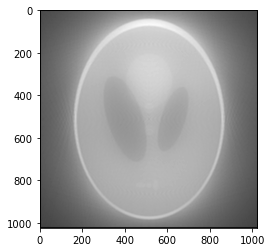

In [16]:
image = io.imread("Shepp_logan.jpg")
image = rgb2gray(image)

sinogram = calculate_sinogram(image, steps=180)
filtered_sinogram = convolve_sinogram(normalize(sinogram, get_max(sinogram)), kernelSize=5)
filtered_image = convolve_image(reverse_radon_transform(filtered_sinogram, steps=180))
plt.imshow(filtered_image, cmap="gray", aspect='equal')